In [2]:
from local_vars import root_folder

data_folder = r"n2a"
image_size = 128

In [3]:
import pandas as pd
import itertools
import os
import keras

from keras.models import Sequential
from keras.layers import Activation, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.utils import Sequence

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from skimage.io import imread
from skimage.transform import resize

Using TensorFlow backend.


In [4]:
data_fullpath = os.path.join(root_folder, data_folder)
train_fullpath = os.path.join(data_fullpath, "train")
valid_fullpath = os.path.join(data_fullpath, "valid")
test_fullpath = os.path.join(data_fullpath, "test")

print("Training data folder:   {}".format(train_fullpath))
print("Validation data folder: {}".format(valid_fullpath))
print("Test data folder:       {}".format(test_fullpath))

Training data folder:   c:\Data\n2a\train
Validation data folder: c:\Data\n2a\valid
Test data folder:       c:\Data\n2a\test


In [11]:
import numpy as np

train_images_fullpath = os.path.join(train_fullpath, "images.npy")
train_classes_fullpath = os.path.join(train_fullpath, "classes.npy")
train_locations_fullpath = os.path.join(train_fullpath, "locations.npy")
train_image_data = np.load(train_images_fullpath)
train_class_data = np.load(train_classes_fullpath)
train_locations_data = np.load(train_locations_fullpath)

num_train_images = train_image_data.shape[0]
train_image_min_value = np.amin(train_image_data)
train_image_max_value = np.amax(train_image_data)

valid_images_fullpath = os.path.join(valid_fullpath, "images.npy")
valid_classes_fullpath = os.path.join(valid_fullpath, "classes.npy")
valid_locations_fullpath = os.path.join(valid_fullpath, "locations.npy")
valid_image_data = np.load(valid_images_fullpath)
valid_class_data = np.load(valid_classes_fullpath)
valid_locations_data = np.load(valid_locations_fullpath)

num_valid_images = valid_image_data.shape[0]
valid_image_min_value = np.amin(valid_image_data)
valid_image_max_value = np.amax(valid_image_data)

test_images_fullpath = os.path.join(test_fullpath, "images.npy")
test_classes_fullpath = os.path.join(test_fullpath, "classes.npy")
test_locations_fullpath = os.path.join(test_fullpath, "locations.npy")
test_image_data = np.load(test_images_fullpath)
test_class_data = np.load(test_classes_fullpath)
test_locations_data = np.load(test_locations_fullpath)

num_test_images = test_image_data.shape[0]
test_image_min_value = np.amin(test_image_data)
test_image_max_value = np.amax(test_image_data)

if train_image_data.shape[1] != image_size:
    raise ValueError("Input image size does not match input size of TF model!")

In [12]:
print("Found training images:   {}".format(num_train_images))
print("Pixel intensity range:   {} to {}".format(train_image_min_value, train_image_max_value))
print("Image size:              {} x {}".format(train_image_data.shape[1], train_image_data.shape[2]))
print("")
print("Found validation images: {}".format(num_valid_images))
print("Pixel intensity range:   {} to {}".format(valid_image_min_value, valid_image_max_value))
print("Image size:              {} x {}".format(valid_image_data.shape[1], valid_image_data.shape[2]))
print("")
print("Found test images:       {}".format(num_test_images))
print("Pixel intensity range:   {} to {}".format(test_image_min_value, test_image_max_value))
print("Image size:              {} x {}".format(test_image_data.shape[1], test_image_data.shape[2]))

Found training images:   5668
Pixel intensity range:   0.0 to 1.0
Image size:              128 x 128

Found validation images: 635
Pixel intensity range:   0.0 to 1.0
Image size:              128 x 128

Found test images:       706
Pixel intensity range:   0.0 to 1.0
Image size:              128 x 128


Example input image with true location


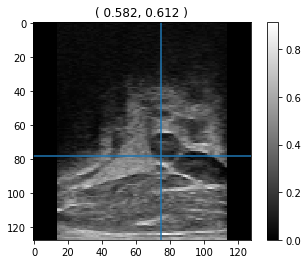

In [13]:
print("Example input image with true location")
plt.title("( {:.3f}, {:.3f} )".format(valid_locations_data[0][0], valid_locations_data[0][1]))
plt.imshow(valid_image_data[0][:,:,0], cmap='gray')
plt.axvline(x=valid_locations_data[0][0] * image_size)
plt.axhline(y=valid_locations_data[0][1] * image_size)
out = plt.colorbar()

In [14]:
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(image_size, image_size, 1)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(2, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
__________

In [15]:
model.compile(SGD(lr=.1), loss='mse', metrics=['accuracy'])

In [25]:
num_epochs = 8
batch_size = 100

history = model.fit(
    train_image_data,
    train_locations_data,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1,
    validation_data=(valid_image_data, valid_locations_data))

Train on 5668 samples, validate on 635 samples
Epoch 1/8
5668/5668 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.8809 - val_loss: 0.0065 - val_acc: 0.8661
Epoch 2/8
5668/5668 [==============================] - 6s 1ms/step - loss: 0.0027 - acc: 0.8814 - val_loss: 0.0068 - val_acc: 0.8661
Epoch 3/8
5668/5668 [==============================] - 6s 1ms/step - loss: 0.0025 - acc: 0.8862 - val_loss: 0.0065 - val_acc: 0.8441
Epoch 4/8
5668/5668 [==============================] - 6s 1ms/step - loss: 0.0023 - acc: 0.8823 - val_loss: 0.0062 - val_acc: 0.8425
Epoch 5/8
5668/5668 [==============================] - 6s 1ms/step - loss: 0.0022 - acc: 0.8859 - val_loss: 0.0062 - val_acc: 0.8425
Epoch 6/8
5668/5668 [==============================] - 6s 1ms/step - loss: 0.0021 - acc: 0.8867 - val_loss: 0.0061 - val_acc: 0.8409
Epoch 7/8
5668/5668 [==============================] - 6s 1ms/step - loss: 0.0021 - acc: 0.8892 - val_loss: 0.0061 - val_acc: 0.8441
Epoch 8/8
5668/5668 [=

Text(0.5,1,'Accuracy Curves')

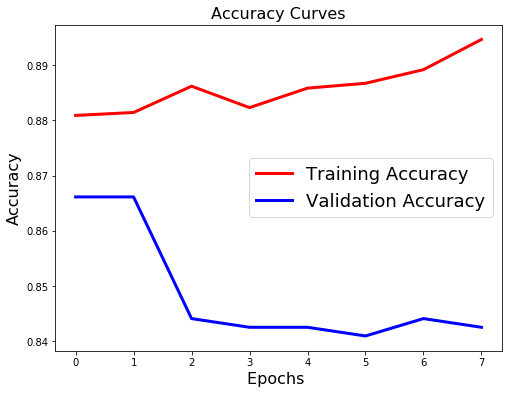

In [26]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [27]:
def plots(ims, ys, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :, 0], cmap='gray')
        plt.axvline(x=ys[i][0] * image_size)
        plt.axhline(y=ys[i][1] * image_size)

In [28]:
y_pred = model.predict(test_image_data)

n = len(test_locations_data)
average_error = 0.0
averaging_factor = 1.0 / n
for i in range(len(test_locations_data)):
    distance = np.linalg.norm(test_locations_data[i] - y_pred[i])
    average_error += distance * averaging_factor

print("Average error: {0:.4f}".format(average_error))    

print("\nTrue locations")
print(test_locations_data[:5])

print("\nPredicted locations")
print(y_pred[:5])

Average error: 0.0705

True locations
[[0.40633631 0.63081715]
 [0.40447885 0.62941009]
 [0.40447885 0.62941009]
 [0.40030345 0.62817964]
 [0.39758134 0.62906957]]

Predicted locations
[[0.48180607 0.5929909 ]
 [0.47798505 0.5934402 ]
 [0.47798505 0.5934402 ]
 [0.47354674 0.5954867 ]
 [0.46944362 0.59656674]]


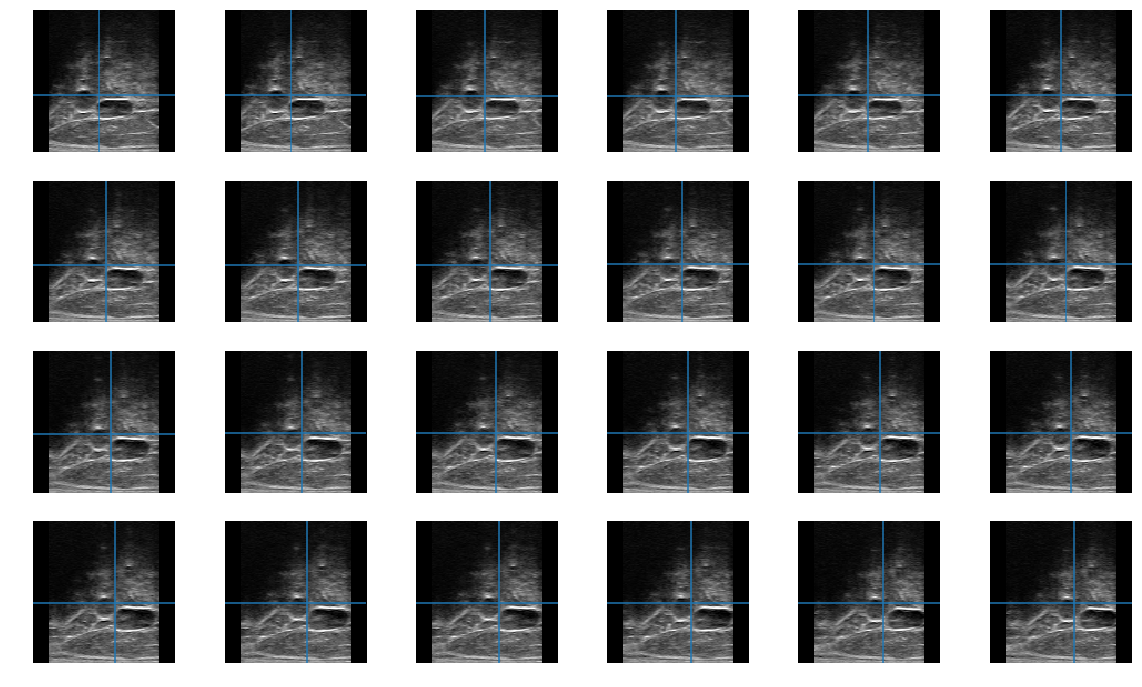

In [29]:
plots(test_image_data[100:124], y_pred[100:124], figsize=(20,12), rows=4)

In [24]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

weights_folder = os.path.join(root_folder, "weights")

if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)
    print("Creating folder: {}".format(weights_folder))

weights_file_name = "weights_" + timestamp + ".h5"
weights_file_path = os.path.join(weights_folder, weights_file_name)

model.save_weights(weights_file_path)